This script can be used to analyze the following burst parameters:
* Intra-burst frequency (Spikes/s = Hz)
* Mean burst length (s)
* Mean bursts/cell/s (/cell/s)

For usage, the <i>filename</i> variable must be changed accordingly. <br>
The <i>pdf_out_filename</i> variable sets the pdf output filename.<br>
<br>
As is, the display only differentiates between angiotensin-II concentrations. Please change accordingly if other or more parameters shall be investigated.<br>
<br>
If the expected burst parameters are changed from WT, <i>maxEventLength</i> (determines the allowed distance between bursts) and <i>minEventInCluster</i> (sets the minimum number of spikes per burst) of the <i>getBursts()</i> function should be adjusted.

<i>Version: 20200424_1_GS</i>

In [1]:
import calim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
# Change filename as needed:
filename = "Cacna1h_KO_Cal520.pkl"

pdf_out_filename = "Burst_Analysis.pdf"

data_pkl = pickle.load(open(filename, "rb"))

In [3]:
def getBursts(eventList, dt=0.1, maxEventLength=5, minEventInCluster=3):
    
    maxEventLength=maxEventLength/dt # Convert the maxEventLength into number of frames
    
    # Group the events into bursts
    if(len(eventList)>0):
        eventList = np.array([e.frame for e in eventList if e.use]) # Only include selected events!
        
        # Create a pseudo 2D Array for DBSCAN
        y = np.zeros_like(eventList)
        XYArray = np.array((eventList, y))

        # DBSCAN is used to cluster the events into bursts
        db = DBSCAN(eps=maxEventLength, min_samples=minEventInCluster).fit(XYArray.T)
        
        burstFrequency=pd.DataFrame([])

        # Iterate over the bursts
        for label in np.unique(db.labels_[db.labels_>-1]):
            # meanFreq contains the frequency within each burst
            meanFreq = 1/(np.mean(np.diff(eventList[db.labels_==label]))*dt)
            # lenEvents contains the number of spikes
            lenEvents = len(eventList[db.labels_==label])
            # length contains the average burst length
            length = (eventList[db.labels_==label][-1]-eventList[db.labels_==label][0])*dt
            # n_bursts contains the number of bursts for this particular cell.
            # This would only have to be saved once per cell but we'll add this information 
            # to each burst for the sake of simplicity in handling the resulting table
            n_bursts = len(np.unique(db.labels_[db.labels_>-1]))
            d = pd.DataFrame(data={"burst_freq": [meanFreq], "burst_num_spikes":[lenEvents], "burst_length":[length], "burst_n":[n_bursts]})
            burstFrequency = pd.concat([burstFrequency, d])
        burstFrequency = burstFrequency.reset_index(drop=True)
        #burstFrequency.columns=["Freq", "NumSpikes", "Length"]
        return burstFrequency
    else:
        return pd.DataFrame()


In [4]:
# The DataFrame "data" will contain all burst information about conditions
data = pd.DataFrame()
print(f"Processing recordings contained in {filename}:")
for recording in data_pkl.recordings:
    print(recording)
    
    r = data_pkl.recordings[recording]

    # Read information for the recording to be added to the final table
    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        if c.use: # Only include if the cell is supposed to be used
            for con in r.conditions: # Iterate over conditions
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                for i, row in getBursts(list(c.get_event(range(info["start"], info["end"]))), dt=r.dt).iterrows():
                    # Append one row for every burst:
                    data = data.append(row.append(pd.Series(info)), ignore_index=True)

# Convert the "burst_n" column from bursts/cell to bursts/cell/second
data["burst_n"] = data["burst_n"]/((data["end"]-data["start"])*data["dt"])
print("Done")

Processing recordings contained in Cacna1h_KO_Cal520.pkl:
200217_s1r2_Results.csv
200218_s1r2_Results.csv
200319_s1r2_Results.csv
200319_s2r1_Results.csv
200320_s1r1_Results.csv
200320_s2r1_Results.csv
200320_s3r1_Results.csv
200320_s4r1_Results.csv
Done


In [5]:
data.describe()

,burst_freq,burst_length,burst_n,burst_num_spikes,dt,end,start
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,1.378636,71.933759,0.008193,104.946988,0.044940,18399.775904,694.096386
std,0.980143,82.890630,0.005742,131.429293,0.011247,9352.583974,1898.792895
min,0.342466,1.300000,0.000833,3.000000,0.020000,3000.000000,0.000000
25%,0.782050,17.050000,0.004308,15.500000,0.050000,12500.000000,0.000000
50%,1.167883,42.000000,0.006667,57.000000,0.050000,13928.000000,0.000000
75%,1.561871,99.950000,0.010000,159.500000,0.050000,24000.000000,0.000000
max,6.052839,659.900000,0.028000,1180.000000,0.050000,45000.000000,6001.000000


<Figure size 432x288 with 0 Axes>

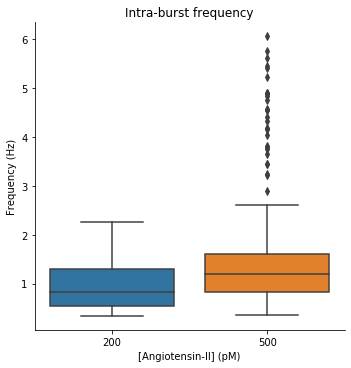

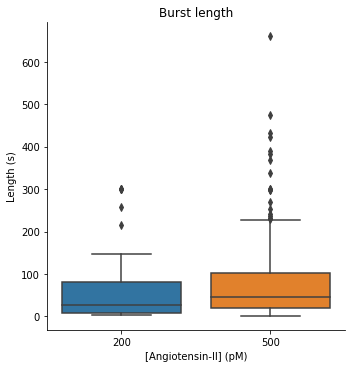

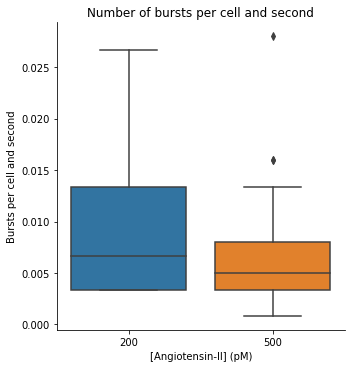

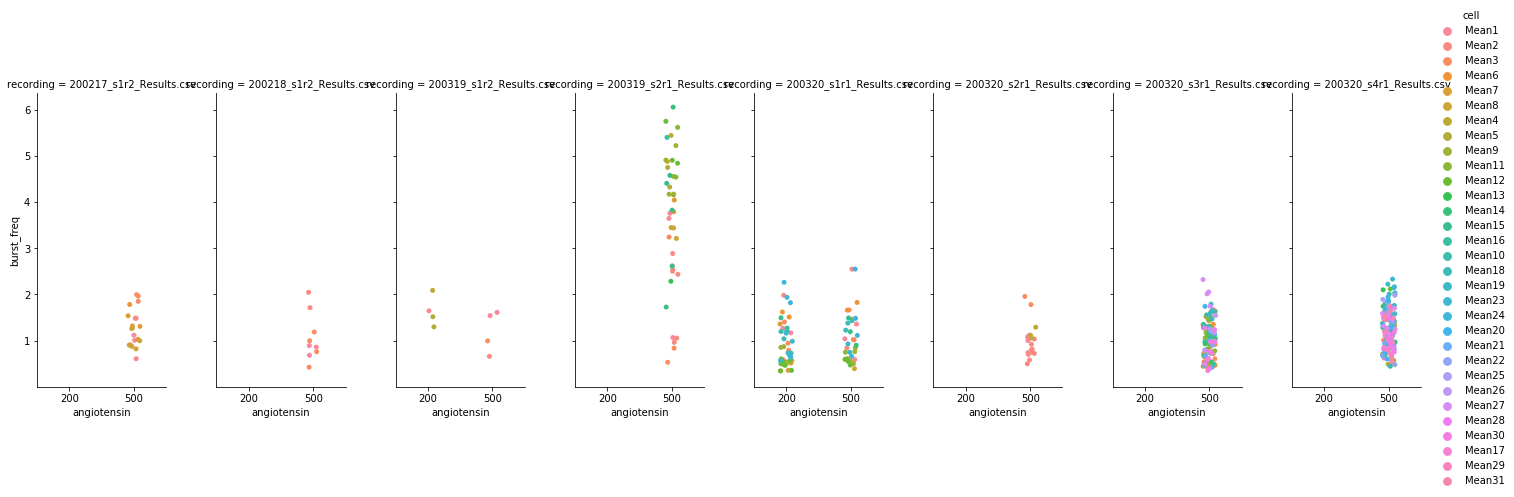

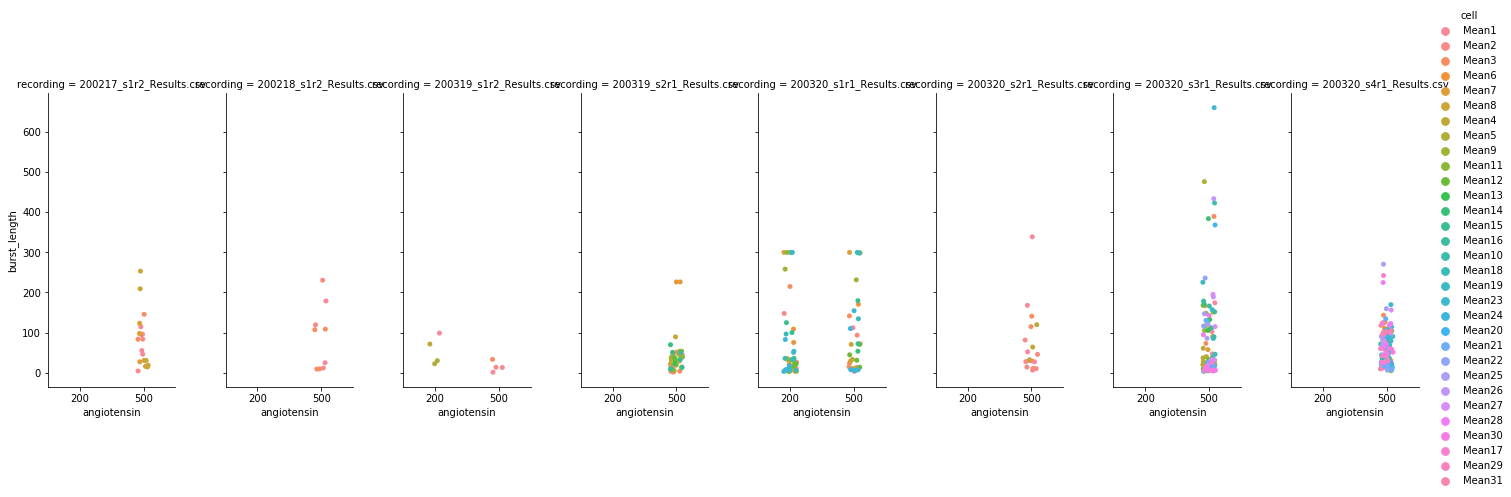

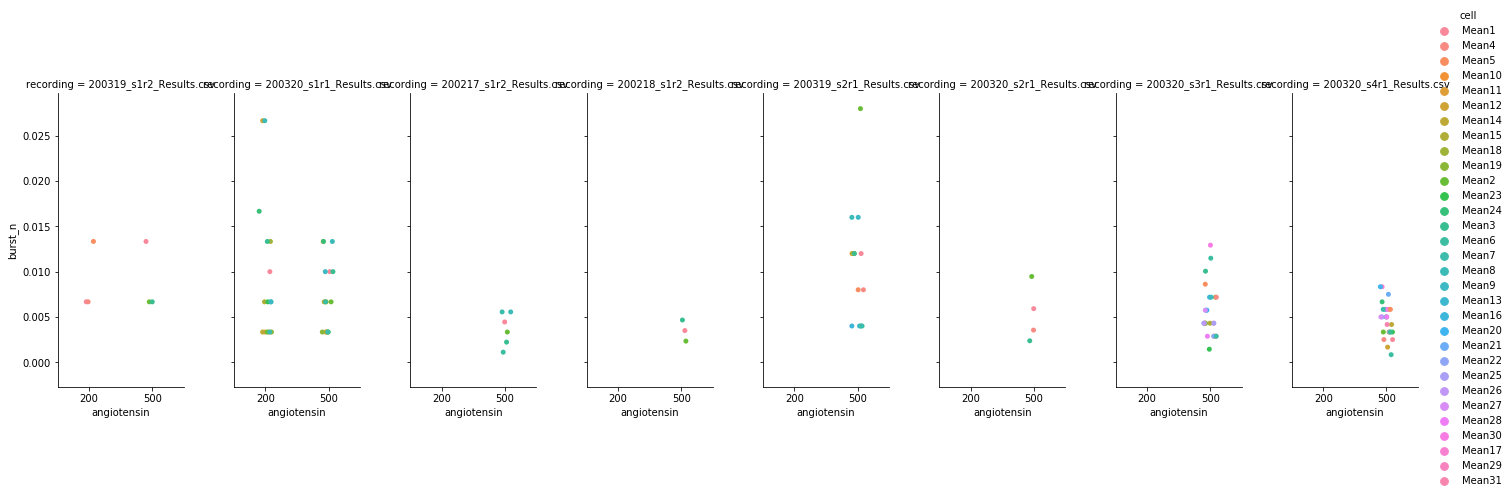

In [16]:
# Please change the display as needed!

with PdfPages(pdf_out_filename) as pdf:

    plt.figure()
    sns.catplot(x="angiotensin", y="burst_freq", data=data, kind="box")
    plt.title("Intra-burst frequency")
    plt.xlabel("[Angiotensin-II] (pM)")
    plt.ylabel("Frequency (Hz)")
    pdf.savefig()
    
    sns.catplot(x="angiotensin", y="burst_length", data=data, kind="box")
    plt.title("Burst length")
    plt.xlabel("[Angiotensin-II] (pM)")
    plt.ylabel("Length (s)")
    pdf.savefig()
    
    n_data = data.groupby(["angiotensin", "recording", "cell"]).mean().reset_index()
    sns.catplot(x="angiotensin", y="burst_n", data=n_data, kind="box")
    plt.title("Number of bursts per cell and second")
    plt.xlabel("[Angiotensin-II] (pM)")
    plt.ylabel("Bursts per cell and second")
    
    pdf.savefig()
    
    
    sns.catplot(x="angiotensin", y="burst_freq", hue="cell", col="recording", data=data, aspect=0.5)
    pdf.savefig()

    sns.catplot(x="angiotensin", y="burst_length", hue="cell", col="recording", data=data, aspect=0.5)
    pdf.savefig()

    sns.catplot(x="angiotensin", y="burst_n", hue="cell", col="recording", data=n_data, aspect=0.5)
    pdf.savefig()
    